The aim of this notebook is to test the LM distance minimization procedure on real image.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue_taylor.adjusters.adjust_annular import set_init_point, prepare_tensions, adjust_tensions
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale

In [27]:
inners = inners[:int(3206/2)]

## Segmentation


Reseting datasets values with new specs


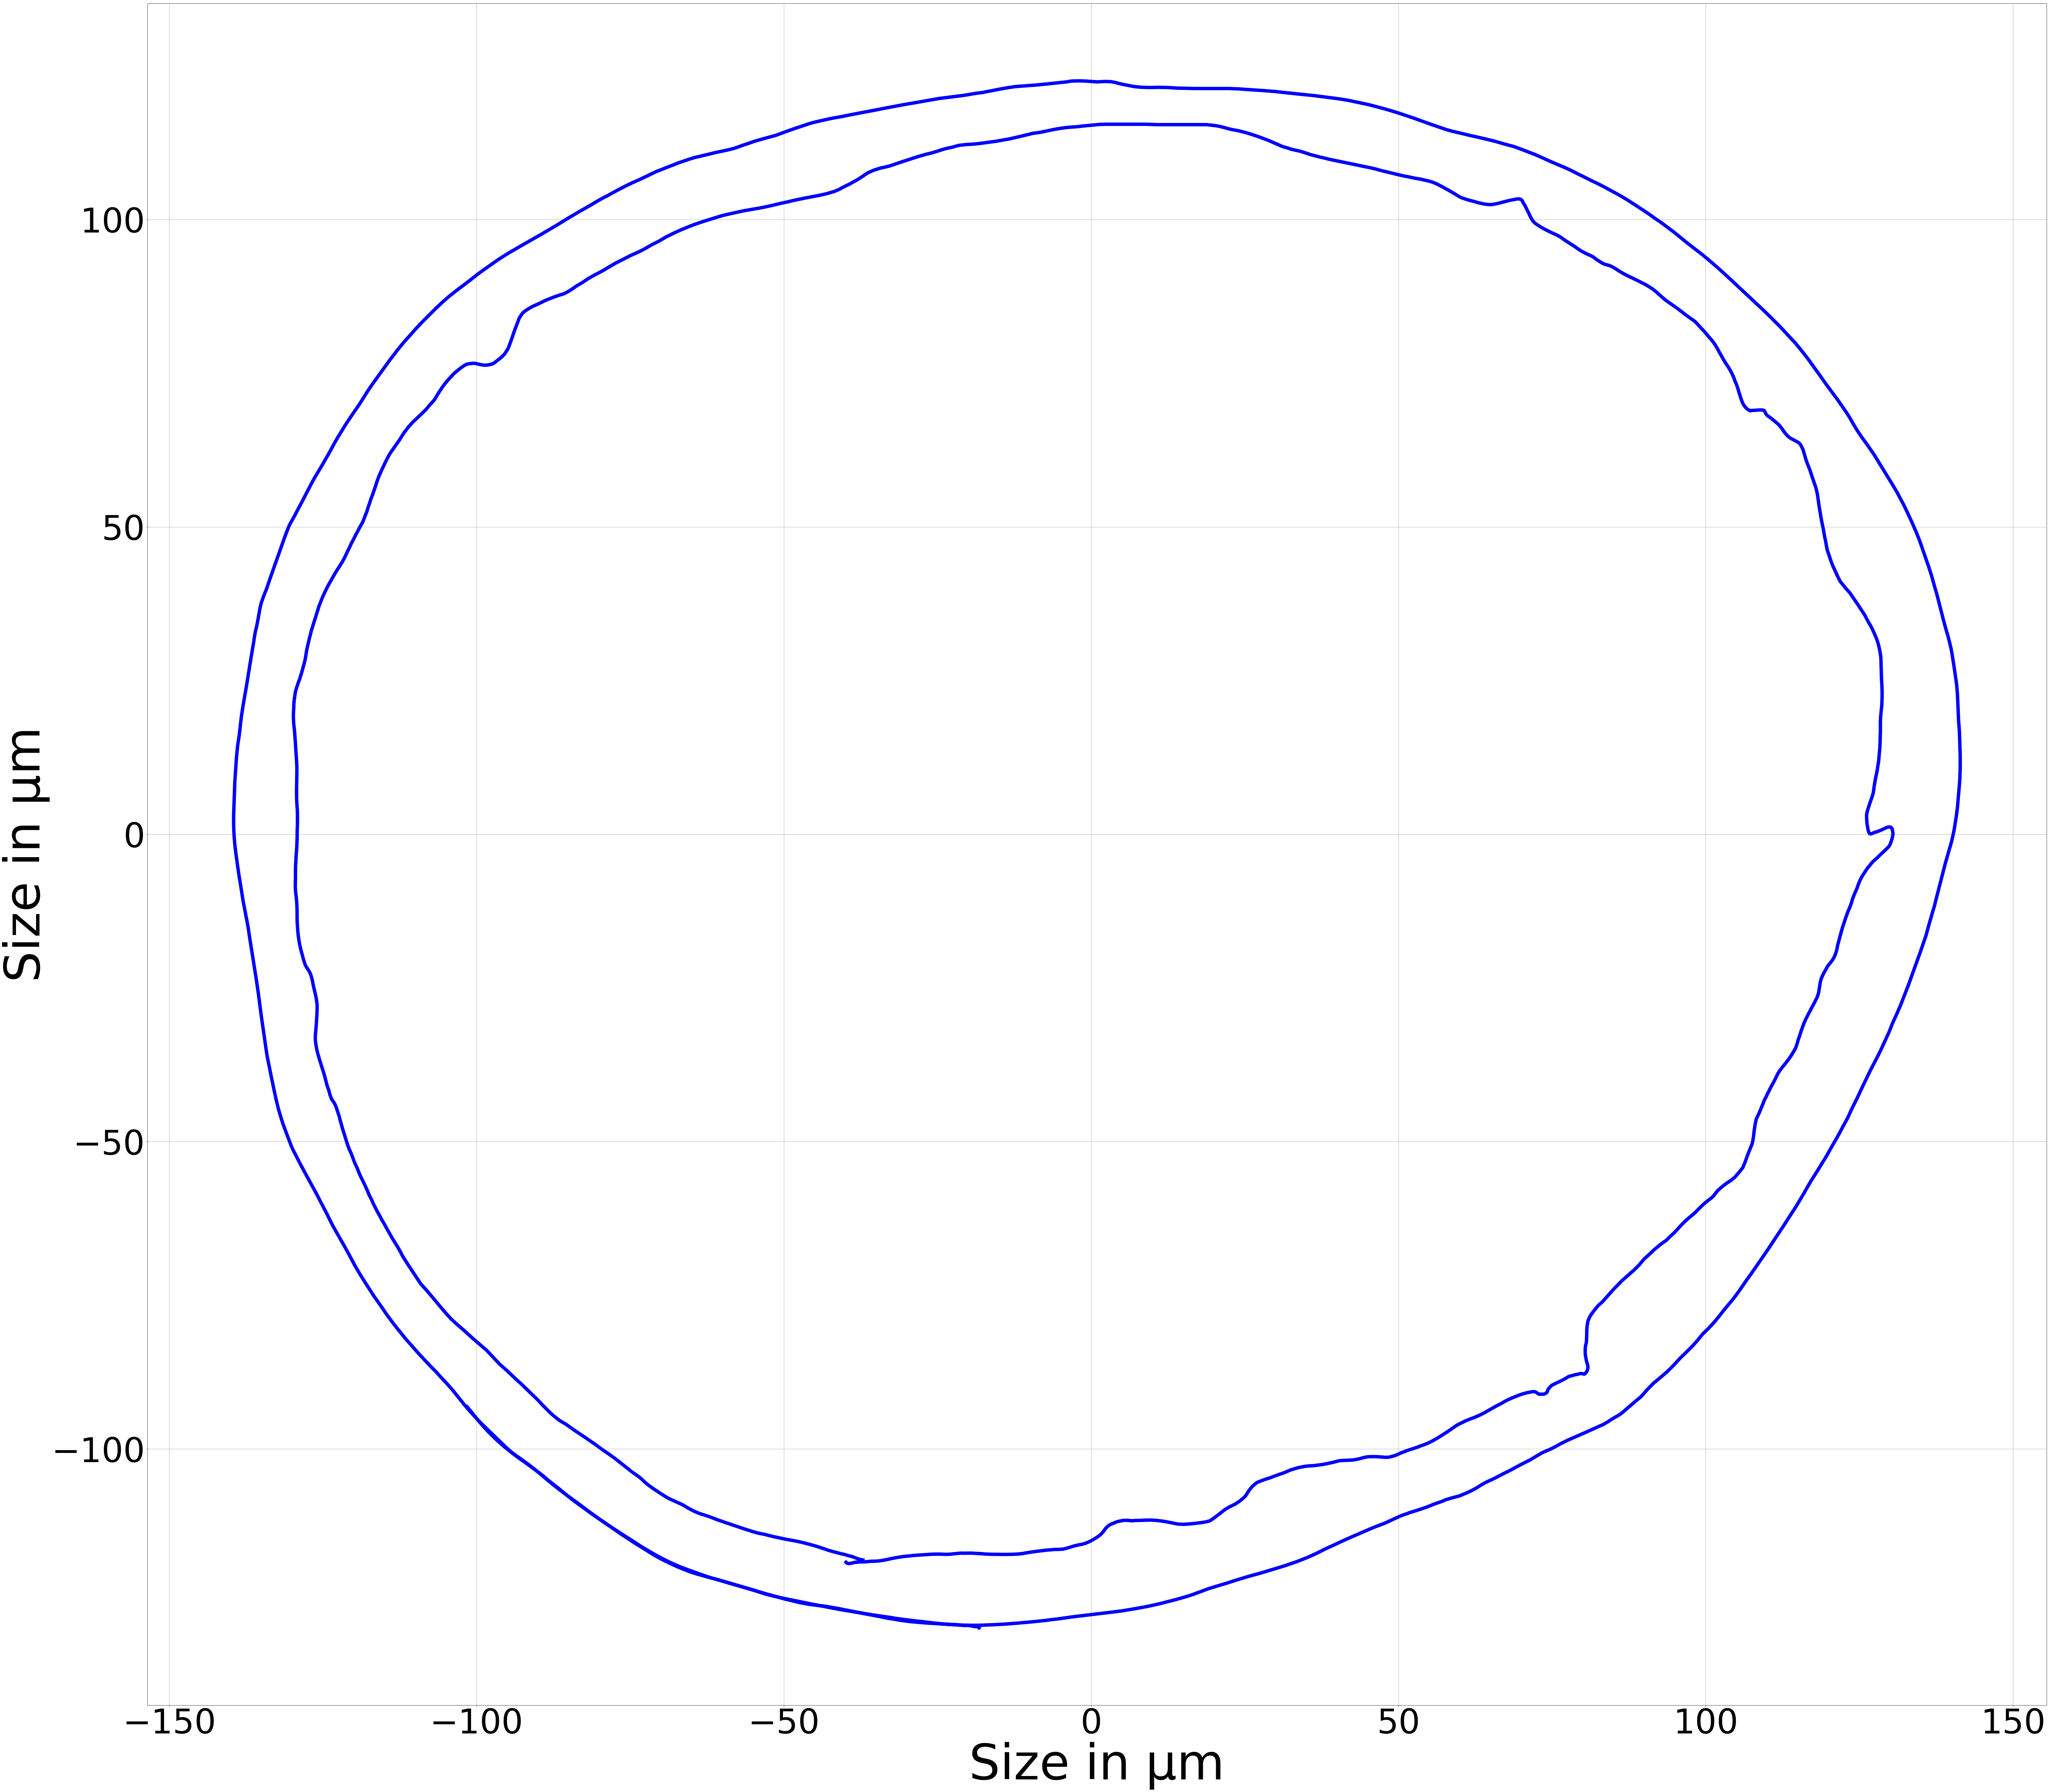

In [40]:
brigthfield_path = '../assets/sample_image_brightfield.tiff'
dapi_path = '../assets/CELLPROFILER_sample_image_dapi.tiff.csv'
#initialising the mesh
organo, inners, outers, centers = generate_ring_from_image(brigthfield_path, dapi_path)
Nf = organo.Nf
geom.update_all(organo)
#normalize_scale(organo, geom)
#alpha as proposed in the doc (in french) https://www.sharelatex.com/read/zdxptpnrryhc
alpha = 1 + 0.005/((organo.settings['R_out']-organo.settings['R_in']))

# Model parameters or specifications
specs = {
    'face':{
        'is_alive': 1,
        'prefered_area':  list(alpha*organo.face_df.area.values), 
        'area_elasticity': 1.,},
    'edge':{        
        'ux': 0.,
        'uy': 0.,
        'uz': 0.,
        'line_tension': 0.1,
        'is_active': 1
        },
    'vert':{
        'adhesion_strength': 0.,
        'x_ecm': 0.,
        'y_ecm': 0.,
        'is_active': 1
        },
    'settings': {
        'lumen_elasticity': 0.1,
        'lumen_prefered_vol': organo.settings['lumen_volume'],
        'lumen_volume': organo.settings['lumen_volume']
        }
    }

organo.update_specs(specs, reset=True)
geom.update_all(organo)
inners = inners[:int(2830/2)]
outers = outers[:int(outers.shape[0]/2)]

organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]

organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01

fig, ax = plt.subplots()
plt.plot(inners[:,0], inners[:,1], 'b-', linewidth=10)
plt.plot(outers[:,0], outers[:,1], 'b-', linewidth=10)
plt.xlabel('Size in µm', fontsize=144)
plt.ylabel('Size in µm', fontsize=144)
plt.tick_params(axis='both', labelsize=100)

plt.gca().set_aspect('equal', adjustable='box')

fig.set_size_inches(100, 100)
ax.grid(linestyle='-', linewidth=1)

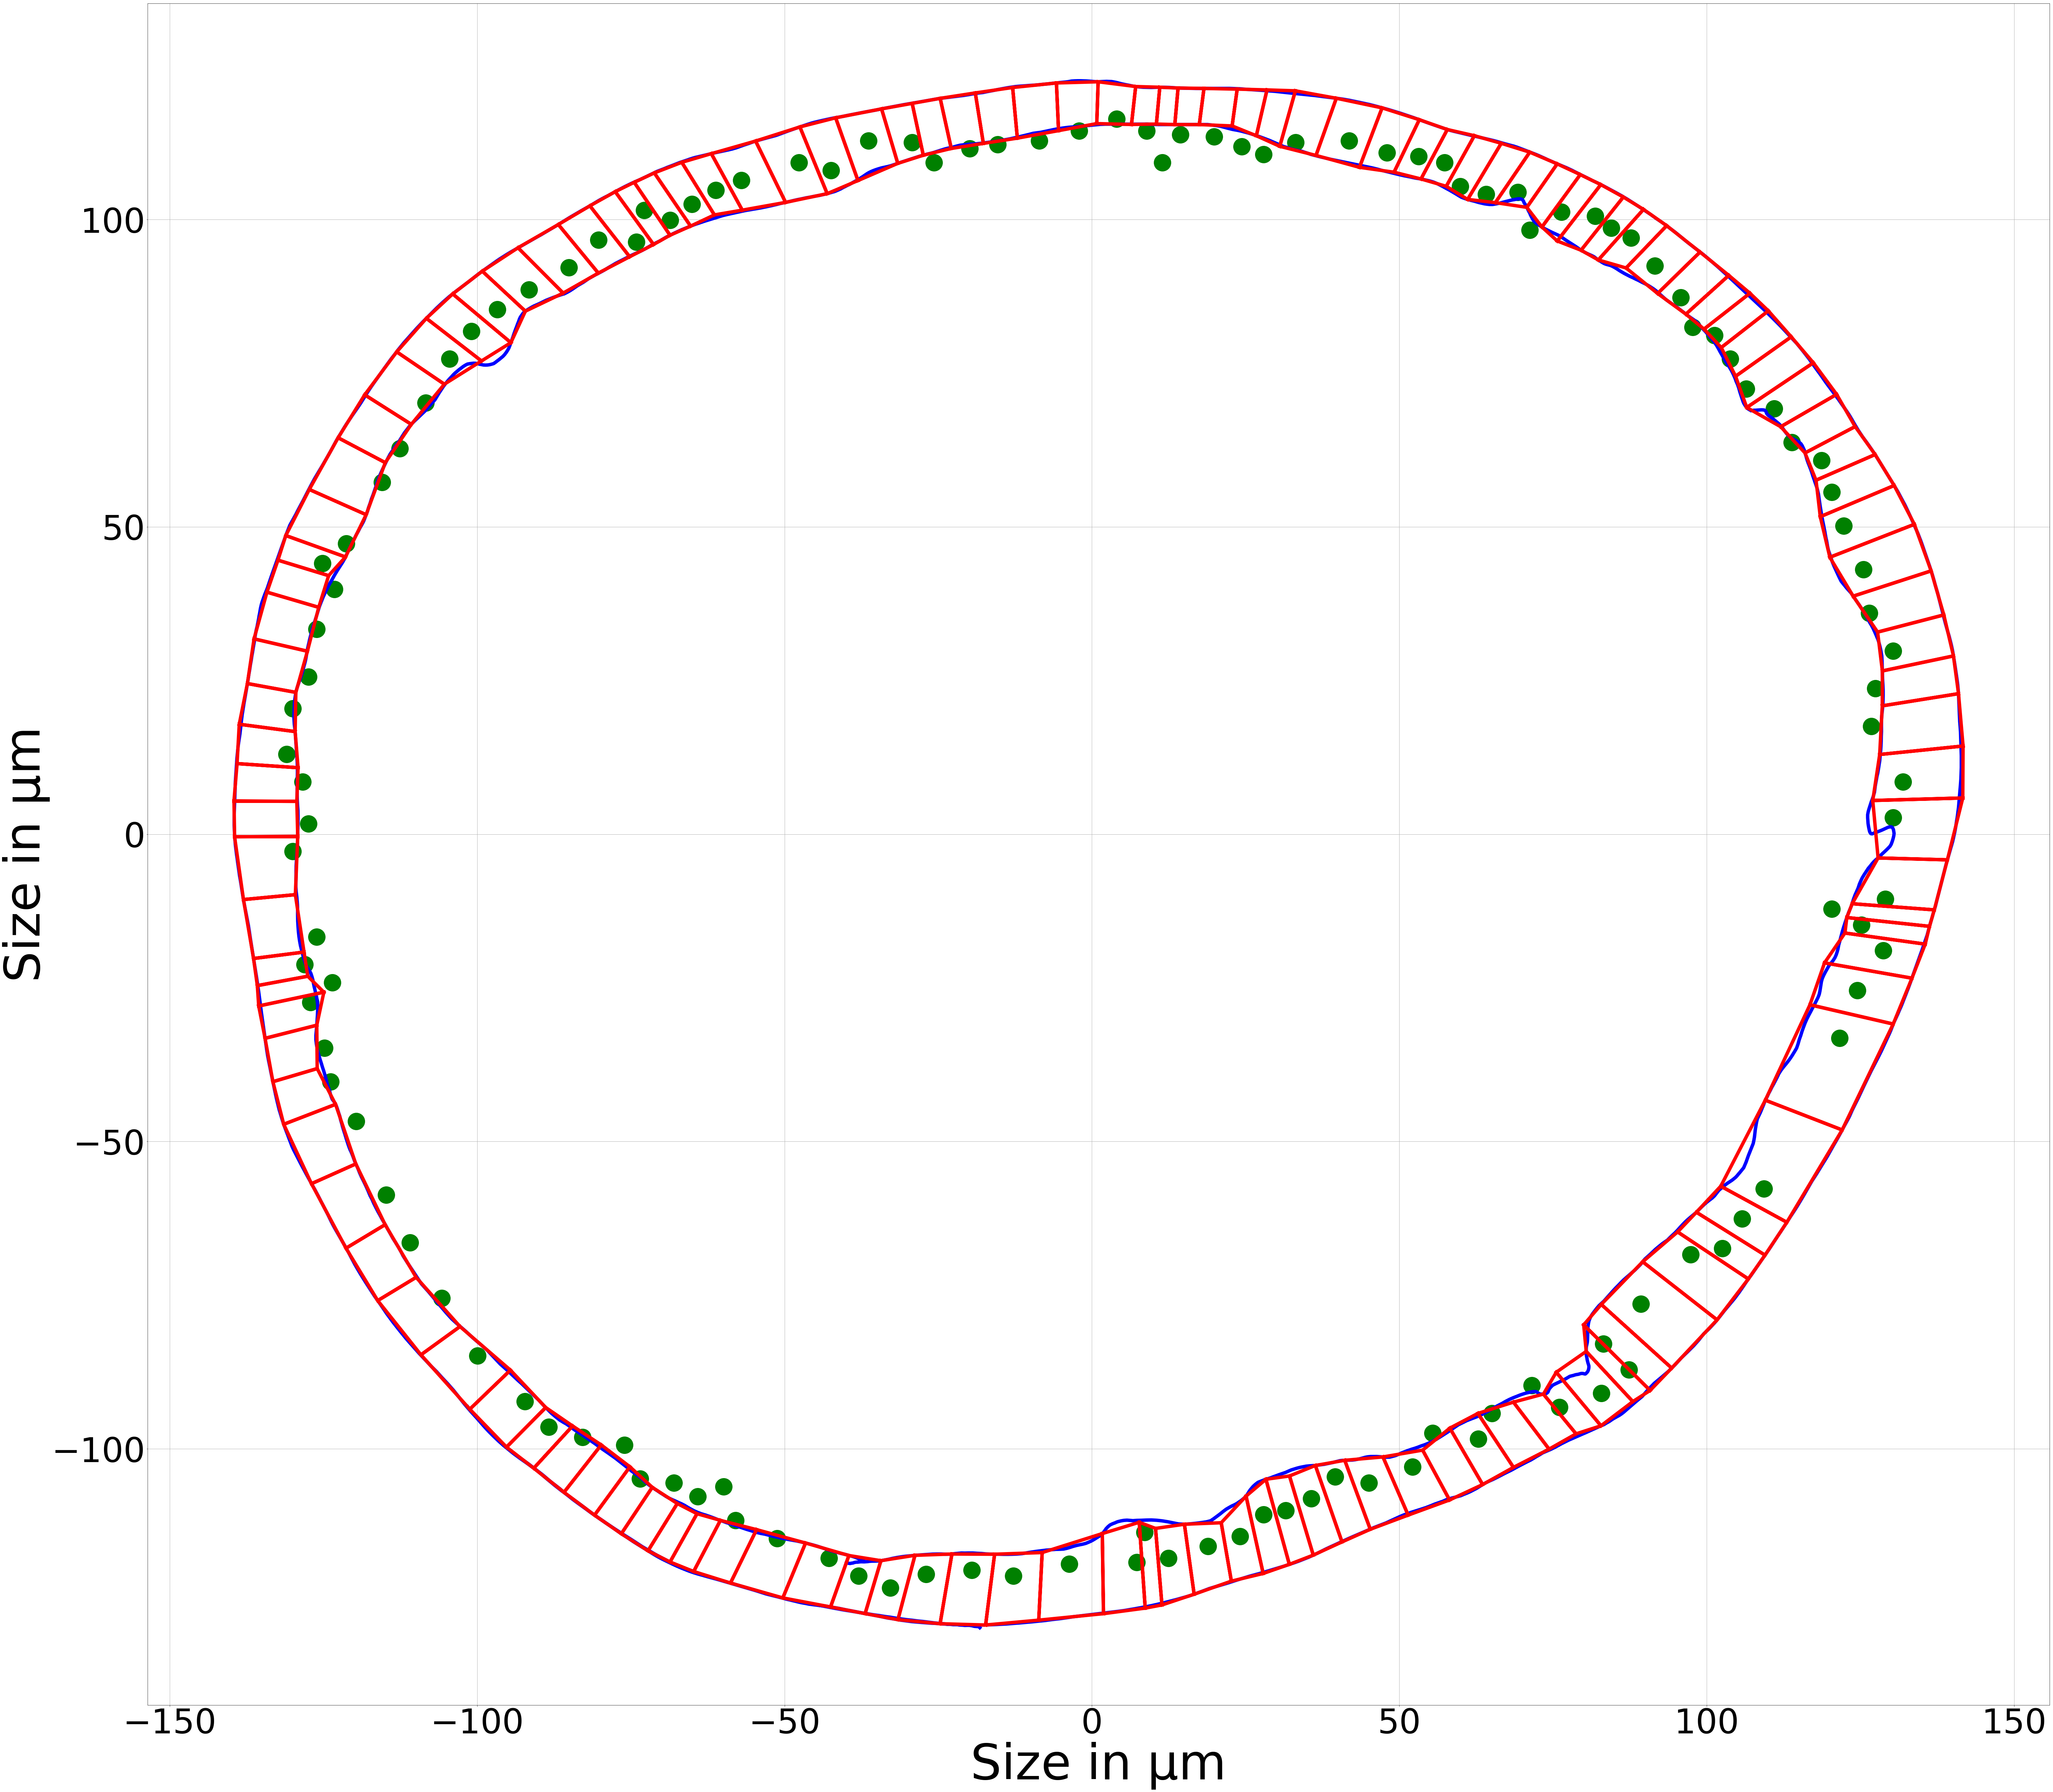

In [41]:
fig, ax = plt.subplots()

plt.plot(centers[:,0], centers[:,1], 'g.', markersize=100)
plt.plot(inners[:,0], inners[:,1], 'b-', linewidth=10)
plt.plot(outers[:,0], outers[:,1], 'b-', linewidth=10)
quick_edge_draw(organo, c='r', ax=ax, linewidth=10)
plt.xlabel('Size in µm', fontsize=144)
plt.ylabel('Size in µm', fontsize=144)
plt.tick_params(axis='both', labelsize=100)

plt.gca().set_aspect('equal', adjustable='box')
fig.set_size_inches(100, 100)
ax.grid(linestyle='-', linewidth=1)

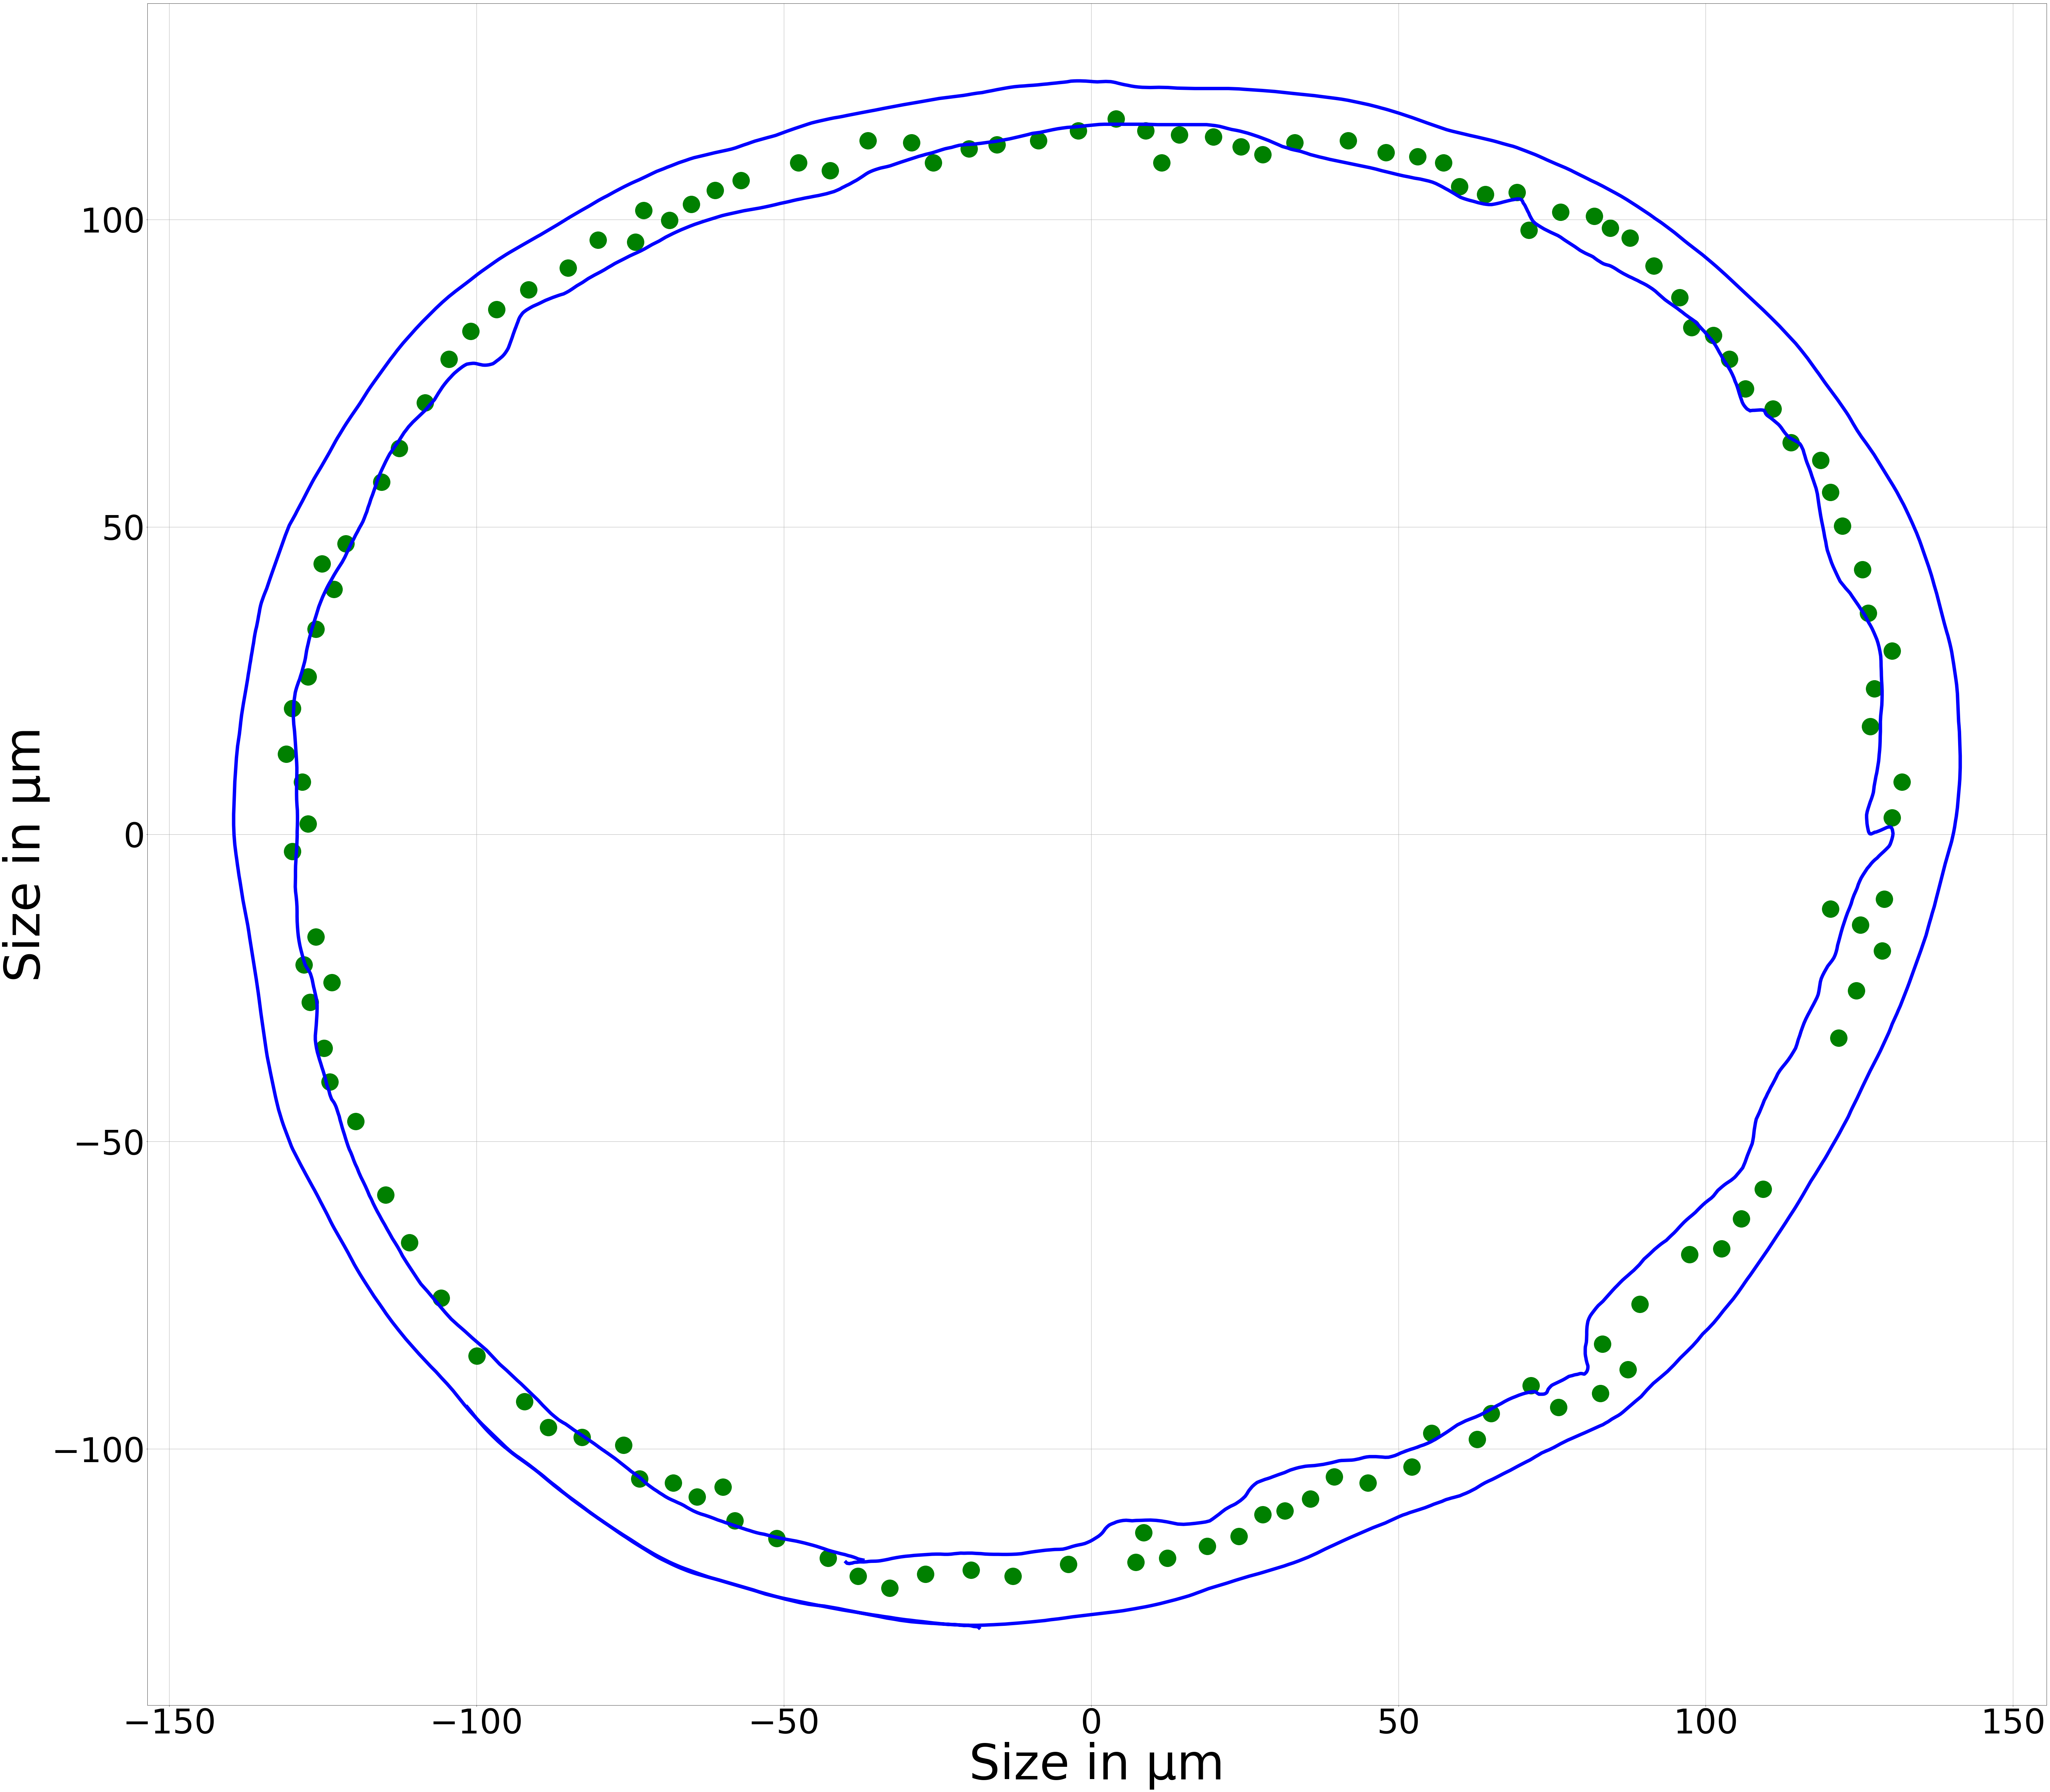

In [42]:
fig, ax = plt.subplots()
plt.plot(centers[:,0], centers[:,1], 'g.', markersize=100)
plt.plot(inners[:,0], inners[:,1], 'b-', linewidth=10)
plt.plot(outers[:,0], outers[:,1], 'b-', linewidth=10)
plt.xlabel('Size in µm', fontsize=144)
plt.ylabel('Size in µm', fontsize=144)
plt.tick_params(axis='both', labelsize=100)

plt.gca().set_aspect('equal', adjustable='box')
fig.set_size_inches(100, 100)
ax.grid(linestyle='-', linewidth=1)

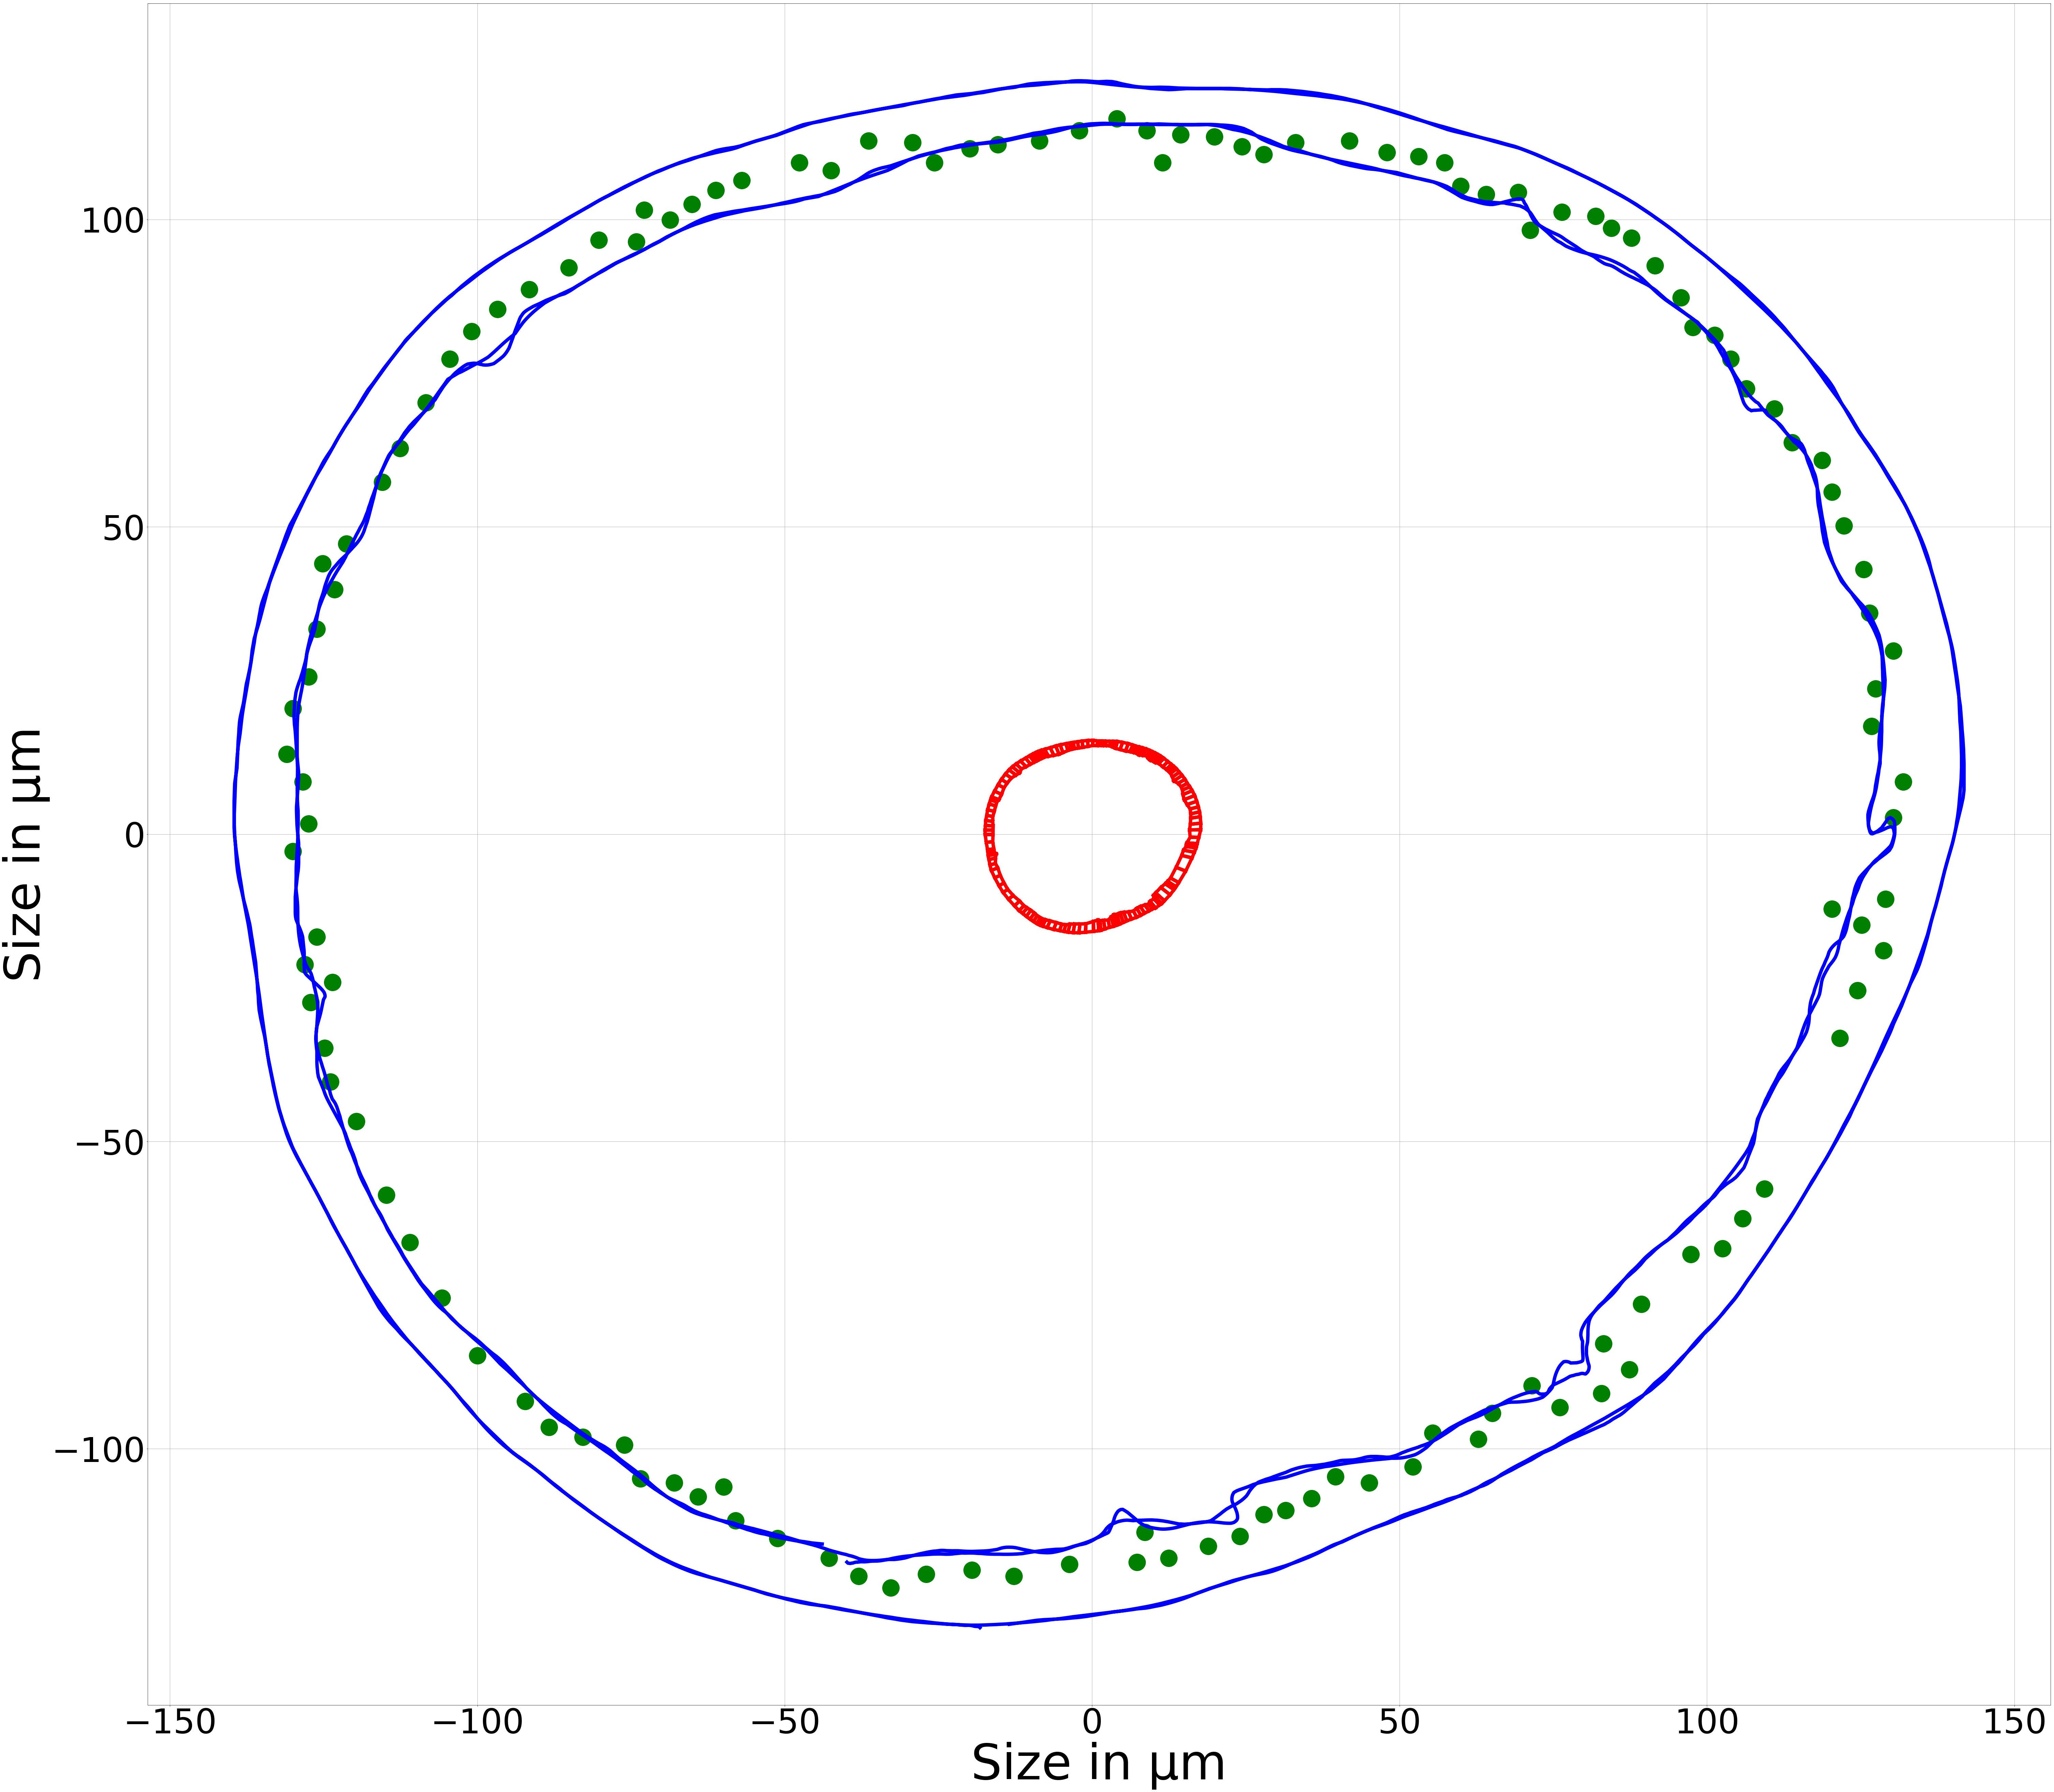

In [19]:
fig, ax = plt.subplots()

plt.plot(centers[:,0], centers[:,1], 'g.', markersize=100)
plt.plot(inners[:,0], inners[:,1], 'b-', linewidth=10)
plt.plot(outers[:,0], outers[:,1], 'b-', linewidth=10)
quick_edge_draw(organo, c='r', ax=ax, linewidth=10)
plt.xlabel('Size in µm', fontsize=144)
plt.ylabel('Size in µm', fontsize=144)
plt.tick_params(axis='both', labelsize=100)

plt.gca().set_aspect('equal', adjustable='box')
fig.set_size_inches(100, 100)
ax.grid(linestyle='-', linewidth=1)

Creating a printing function

In [20]:
def print_tensions(exp_organo, th_organo):
    draw_specs = sheet_spec()
    tension_max = np.max(exp_organo.edge_df.line_tension.values.copy())
    edge_color = 1/tension_max*exp_organo.edge_df.line_tension.values.copy()
    cmap = plt.cm.get_cmap('viridis')
    edge_cmap = cmap(edge_color)
    draw_specs['vert']['visible'] = False
    draw_specs['edge']['color'] = edge_cmap
    draw_specs['edge']['width'] = 0.25+3*edge_color
    fig, ax = quick_edge_draw(th_organo, lw=5, c='k', alpha=0.2)
    fig, ax = sheet_view(exp_organo, ax=ax, **draw_specs)
    fig.set_size_inches(12, 12)
    plt.xlabel('Size in µm')
    plt.ylabel('Size in µm')

Define the optimization parameters

In [21]:
energy_opt = {'options': {'gtol': 1e-5, 'ftol': 1e-5}}


bfgs_opt = {'method': 'bfgs','options': {'gtol':1e-1,'ftol': 1e-5}}
trf_opt = {'bounds': ([-1e-8]*(3*organo.Nf),[1000]*(3*organo.Nf)), 
           'method': 'trf','xtol':1e-8,'ftol': 1e-5, 'verbose': 2}
lm_opt = {'method': 'lm','xtol':1e-15,'ftol': 1e-15, 'verbose': 1}
psqp_opt = {'lb': 0, 'ub': 1e6, 'method': 'dist_PSQP', 'output_path': './PSQP_min_dist'}

reg_weight = 1e-3
theta = 0.02

## Starting the optimization procedure

In [22]:
initial_guess = set_init_point(organo.settings['R_in'], organo.settings['R_out'], organo.Nf, alpha)
copy_lm_nr_nl = organo.copy()

In [24]:
resc_lm_nr_nl

 active_mask: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Energy before optimization:  26.974810671950554
{'norm_factor': 1, 'minimize': {'method': 'L-BFGS-B', 'options': {'disp': False, 'ftol': 1e-06, 'gtol': 0.001}}}
{'norm_factor': 1, 'minimize': {'method': 'L-BFGS-B', 'options': {'gtol': 1e-05, 'ftol': 1e-05}}}
`xtol` termination condition is satisfied.
Function evaluations 3551, initial cost 2.5714e+01, final cost 2.4840e+01, first-order optimality 5.64e+04.
Solving time: 10644.023202
Energy after optimization:  7.128050562209038
Tension error: [0.09087975 0.0896612  0.08944597 0.08898115 0.09079087 0.09003581
 0.08885973 0.08940214 0.08991765 0.08838382 0.08985299 0.08861246
 0.090213   0.09241427 0.08969641 0.09080797 0.09001494 0.09035877
 0.09628976 0.08721789 0.08005555 0.09069327 0.08759585 0.09410241
 0.08729473 0.08741142 0.08982595 0.09247278 0.09273057 0.09134923
 0.09220246 0.08736466 0.08969066 0.0948825  0.0890633  0.0927079
 0.09428327 0.08229671 0.09037974 0.0945251  0.08542316 0.09278589
 0.08721801 0.09019326 0.0908533  

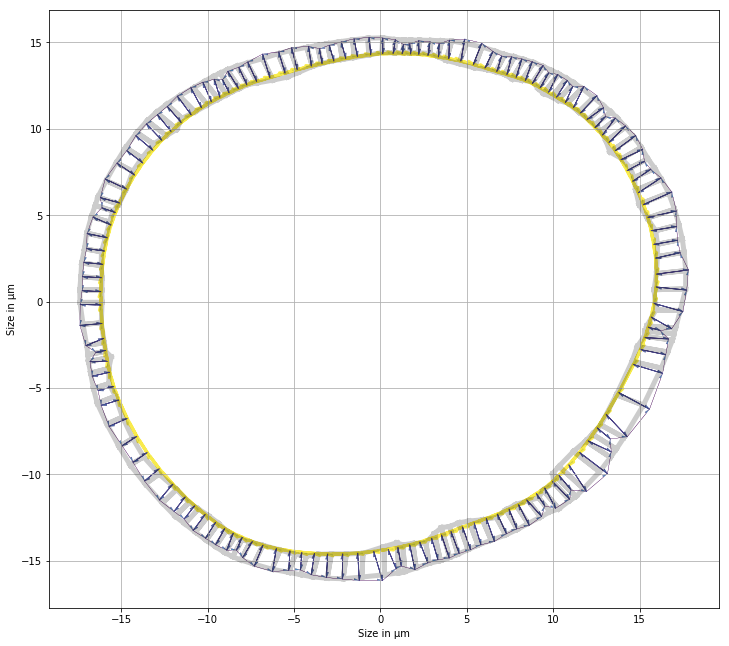

In [23]:
start = time.clock()
print('Energy before optimization: ', model.compute_energy(copy_lm_nr_nl, False))
resc_lm_nr_nl = adjust_tensions(copy_lm_nr_nl, initial_guess, {'dic':{}, 'weight':0},
                                energy_opt, **lm_opt)
copy_lm_nr_nl.edge_df.line_tension = prepare_tensions(copy_lm_nr_nl, resc_lm_nr_nl.x)
Solver.find_energy_min(copy_lm_nr_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Energy after optimization: ', model.compute_energy(copy_lm_nr_nl, False))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-resc_lm_nr_nl.x),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_lm_nr_nl, organo)

Solving time: 43017.667308
Energy after optimization:  67.2762020859654
Tension error: [8.10532072 8.10539098 8.10487978 8.10531624 8.10503461 8.10532539
 8.10543537 8.10532729 8.10532365 8.10539783 8.10555581 8.10478741
 8.10478383 8.10532977 8.10366365 8.10335193 8.10616099 8.1060515
 8.10469617 8.10535559 8.10474388 8.10569009 8.10535578 8.10620023
 8.10712793 8.10572776 8.10528447 8.10532364 8.10532237 8.10532229
 8.10532228 8.10532918 8.10591408 8.10522512 8.10532362 8.10532795
 8.10548226 8.10522907 8.10558623 8.10573373 8.1053083  8.10564461
 8.10502598 8.10733304 8.10533508 8.10506741 8.10533039 8.10532716
 8.10533071 8.10550206 8.1051587  8.10532277 8.10531773 8.10532772
 8.10532026 8.1048808  8.10514322 8.10519114 8.10530618 8.10530037
 8.10560649 8.10596012 8.1053349  8.10519645 8.10531525 8.10531983
 8.10532263 8.10534155 8.10530971 8.10600622 8.1048675  8.10520134
 8.10532163 8.10539997 8.10666827 8.1054256  8.10626366 8.10531191
 8.1048122  8.10427483 8.105331   8.1050962

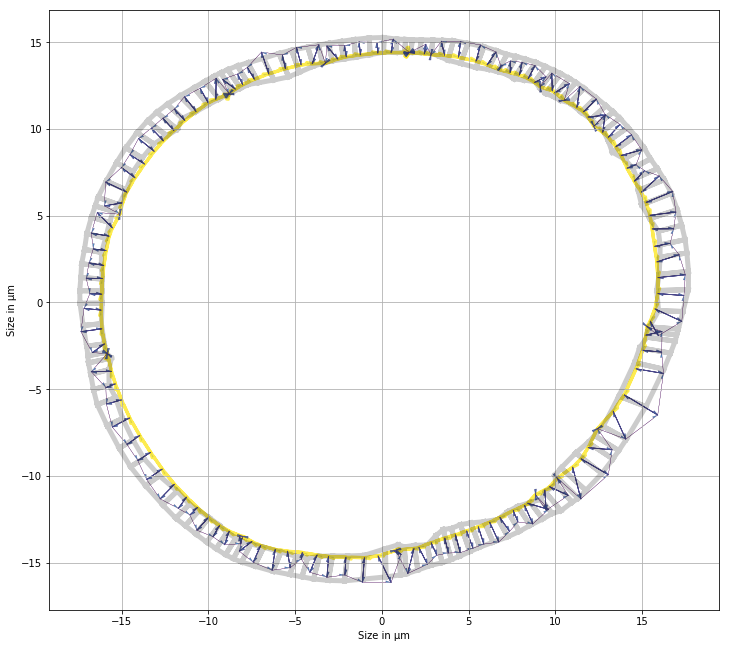

In [7]:
copy_lm_nr_nl.edge_df.line_tension = prepare_tensions(copy_lm_nr_nl, resc_lm_nr_nl['x'])
Solver.find_energy_min(copy_lm_nr_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Energy after optimization: ', model.compute_energy(copy_lm_nr_nl, False))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-resc_lm_nr_nl['x']),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_lm_nr_nl, organo)

inf 0.0


/home/fquinton/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/fquinton/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


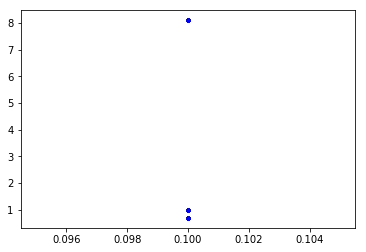

In [9]:
var_tens = np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-resc_lm_nr_nl['x']),
                     np.full(resc_lm_nr_nl['x'].shape, organo.edge_df.line_tension[:3*organo.Nf].mean()))
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(organo.edge_df.line_tension.values[:3*Nf] ,var_tens)
print(std_err, r_value)
plt.plot(organo.edge_df.line_tension.values[:3*Nf], var_tens, 'b.')
plt.plot(organo.edge_df.line_tension.values[:3*Nf], intercept+slope*organo.edge_df.line_tension.values[:3*Nf],
        'r-')